# Lake Washington Wetland Metagenome Functional Gene Analysis
**Zach Flinkstrom**\
*The purpose of this notebook is to compare gene abundance profiles from freshwater wetland soil samples taken across seasons and soil depths.*\
\
**Notebook Outline:**
* Load data (estimated copies of KEGG KOs for each sample, from JGI IMG/M)
* Normalize KO abundance data
* Test for difference and correlations in KO abundance across seasons and depths
* Perform distance-based analysis on KO abundance data
* Compare functional diversity across seasons and depths
* Perform functional analysis based on KEGG Modules
* Perform functional analysis based on KEGG Categories

In [1]:
#import necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
import seaborn as sns
from scipy import stats
from scipy.stats import dirichlet
from scipy.spatial.distance import pdist, squareform
from statsmodels.stats.multitest import fdrcorrection
from skbio.stats import distance, ordination
from skbio import diversity
from scikit_posthocs import posthoc_dunn
from textwrap import wrap
from random import sample
import requests
import json

/mnt/c/Users/Zach_Flinkstrom/Documents/ubuntu/.conda/envs/wetland_study/lib/python3.12/site-packages/numpy/_core/getlimits.py:548: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


## Load data

In [2]:
# Load data tsv containing KO estimated gene copies for each sample
data = pd.read_csv('data/KO_est_copies.txt', sep = '\t')
data.drop('Unnamed: 38', axis=1, inplace=True)
data.set_index(['Function ID', 'Function Name'], inplace=True)
new_column_names = dict(zip(list(data.columns), [int(i.split()[-1]) for i in list(data.columns)])) #gets just the IMG ID for column name
data.rename(columns=new_column_names, inplace=True)
data.head()

,,3300051019,3300051162,3300051161,3300051208,3300051207,3300051206,3300052722,3300052920,3300052919,3300056874,...,3300056595,3300060274,3300061209,3300061208,3300060272,3300060271,3300060275,3300060276,3300061215,3300061210
Function ID,Function Name,,,,,,,,,,,,,,,,,,,,,
KO:K00001,alcohol dehydrogenase [EC:1.1.1.1],1837,1431,1218,1126,1319,1454,1985,2216,1146,2566,...,1038,750,2780,2007,570,1046,1147,1290,2082,1496
KO:K00002,alcohol dehydrogenase (NADP+) [EC:1.1.1.2],410,225,194,141,269,274,233,214,220,293,...,245,159,363,394,104,226,142,138,330,297
KO:K00003,homoserine dehydrogenase [EC:1.1.1.3],14110,8442,6142,5625,7240,8315,9642,10807,7383,13280,...,6397,5133,13352,10179,3965,6254,6907,7136,11341,7802
KO:K00004,"(R,R)-butanediol dehydrogenase / meso-butanediol dehydrogenase / diacetyl reductase [EC:1.1.1.4 1.1.1.- 1.1.1.303]",2753,1649,1152,597,776,826,1841,1687,710,2729,...,560,395,2021,985,664,656,807,1113,1563,608
KO:K00005,glycerol dehydrogenase [EC:1.1.1.6],1642,803,682,407,505,505,1202,1356,570,1353,...,487,316,1746,887,485,426,669,765,1360,475


In [3]:
# Read in sample metadata
metadata = pd.read_csv('data/metadata.txt', sep = '\t')
metadata.drop('Unnamed: 95', axis=1, inplace=True)
metadata.set_index('taxon_oid', inplace=True)
metadata.head()

,Domain,Sequencing Status,Study Name,Genome Name / Sample Name,Sequencing Center,IMG Genome ID,Genome Size * assembled,Gene Count * assembled,Scaffold Count * assembled,Genome MetaBAT Bin Count * assembled,...,SRA ID,SRA Run,JGI Data Utilization Status,GPTS Proposal ID,Number of Filtered Reads * assembled,Number of Mapped Reads * assembled,% Assembled Reads * assembled,Total Filtered Bases * assembled,Total Mapped Bases * assembled,Average Coverage of Assembled Sequences * assembled
taxon_oid,,,,,,,,,,,,,,,,,,,,,
3300060276,*Microbiome,Permanent Draft,Soil microbial communities from wetlands in Wa...,Soil microbial communities from lacustrine wet...,DOE Joint Genome Institute (JGI),3300060276,1398886144,2339244,1311805,24,...,NaN,NaN,Restricted,NaN,337137028,129231645,38.33,50491447400,19354423465,13.84
3300061209,*Microbiome,Complete,Soil microbial communities from wetlands in Wa...,Soil microbial communities from lacustrine wet...,DOE Joint Genome Institute (JGI),3300061209,2741840948,4384885,2356833,48,...,NaN,NaN,Restricted,NaN,0,0,0.00,0,0,0.00
3300056859,*Microbiome,Permanent Draft,Soil microbial communities from wetlands in Wa...,Soil microbial communities from lacustrine wet...,DOE Joint Genome Institute (JGI),3300056859,605831085,1027974,581621,13,...,NaN,NaN,Restricted,NaN,199558654,58612229,29.37,29897055005,8781042561,14.49
3300056874,*Microbiome,Permanent Draft,Soil microbial communities from wetlands in Wa...,Soil microbial communities from lacustrine wet...,DOE Joint Genome Institute (JGI),3300056874,2540634364,4055662,2164308,44,...,NaN,NaN,Restricted,NaN,478622064,233010024,48.68,71718218494,34914946613,13.74
3300052920,*Microbiome,Permanent Draft,Soil microbial communities from wetlands in Wa...,Soil microbial communities from lacustrine wet...,DOE Joint Genome Institute (JGI),3300052920,2160146191,3704196,2182795,28,...,NaN,NaN,Restricted,NaN,457563950,222018600,48.52,68579945427,33276274216,15.40


In [4]:
#Add metadata columns for sample season, depth, and core
month_mapper = {'LW1':'Oct', 'LW2':'Feb', 'LW3':'May', 'LW4':'Aug'} #maps sampling campaign code to month
core_mapper = {'Top':10, 'Mid':30, 'Btm':50}
name_list = [i.split()[-1].split('_') for i in metadata['Genome Name / Sample Name']] #breaks down into sampling campaign, core#, depth
month_list = [month_mapper[i[0]] for i in name_list]
core_list = [i[1] for i in name_list]
depth_list = [i[2] for i in name_list]
depth_cm_list = [core_mapper[i[2]] for i in name_list]
# Add to metadata dataframe
metadata['month'] = month_list
metadata['core'] = core_list
metadata['depth'] = depth_list
metadata['depth_cm'] = depth_cm_list

## Normalize data

In [5]:
#ALDEx2 like Monte-Carlo sampling and normalization of data
MC_instance = 16
for i in range(MC_instance):
    new_mat = np.zeros_like(data, dtype=float)
    print(i)
    for col in range(np.shape(data)[1]):
        new_mat[:,col] = dirichlet.rvs(data.iloc[:, col]+0.5)[0]
    
    geometric_mean = stats.gmean(new_mat, axis=0)
    if i == 0:
        new_clr = np.log2(new_mat/geometric_mean)
    else:
        new_clr = (new_clr + np.log2(new_mat/geometric_mean))/2.

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


In [6]:
norm_data = pd.DataFrame(new_clr, index=data.index, columns=data.columns)
norm_data.head()

,,3300051019,3300051162,3300051161,3300051208,3300051207,3300051206,3300052722,3300052920,3300052919,3300056874,...,3300056595,3300060274,3300061209,3300061208,3300060272,3300060271,3300060275,3300060276,3300061215,3300061210
Function ID,Function Name,,,,,,,,,,,,,,,,,,,,,
KO:K00001,alcohol dehydrogenase [EC:1.1.1.1],5.157988,5.320007,5.313193,4.928813,4.680192,4.507250,5.182109,5.077986,4.637080,5.327367,...,4.662250,4.505272,5.249151,4.619537,5.032795,4.680255,4.955140,5.320377,4.996191,4.707271
KO:K00002,alcohol dehydrogenase (NADP+) [EC:1.1.1.2],3.047338,2.607653,2.759021,1.819103,2.373437,2.167904,2.111675,1.745313,2.249068,2.089227,...,2.540192,2.308230,2.310530,2.259578,2.522678,2.506295,1.892403,1.993212,2.283772,2.423351
KO:K00003,homoserine dehydrogenase [EC:1.1.1.3],8.102030,7.902062,7.649192,7.257803,7.135915,7.012055,7.483211,7.374967,7.308101,7.690881,...,7.248989,7.237560,7.516364,6.968030,7.815915,7.270238,7.476808,7.785075,7.455478,7.093935
KO:K00004,"(R,R)-butanediol dehydrogenase / meso-butanediol dehydrogenase / diacetyl reductase [EC:1.1.1.4 1.1.1.- 1.1.1.303]",5.753507,5.575878,5.259439,3.998206,3.894369,3.652555,5.076925,4.705156,3.955808,5.401249,...,3.777921,3.585770,4.796588,3.589824,5.254089,4.040960,4.396805,5.122453,4.591678,3.448492
KO:K00005,glycerol dehydrogenase [EC:1.1.1.6],4.983559,4.520707,4.468940,3.429950,3.276569,2.971075,4.504371,4.389076,3.654898,4.396131,...,3.550831,3.222890,4.626330,3.458590,4.762131,3.377422,4.184518,4.547063,4.415871,3.179043


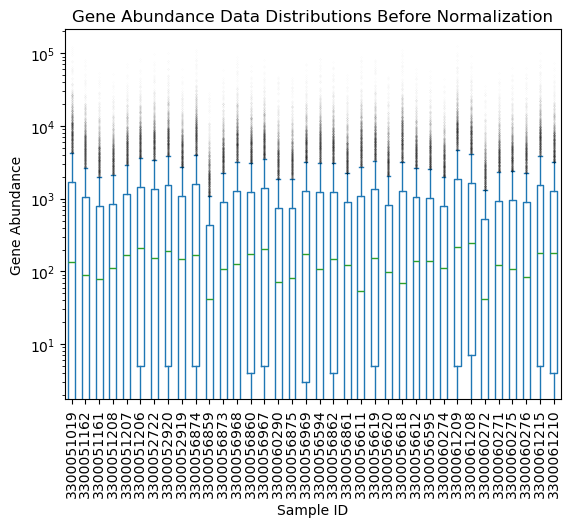

In [7]:
# Visualize data before clr normalization
data.plot(kind='box', flierprops={'markersize': 0.01})
plt.xticks(rotation=90)
plt.xlabel('Sample ID')
plt.ylabel('Gene Abundance')
plt.title('Gene Abundance Data Distributions Before Normalization')
plt.yscale('log')
plt.show()

Clearly shows skew in abundance data before normalization

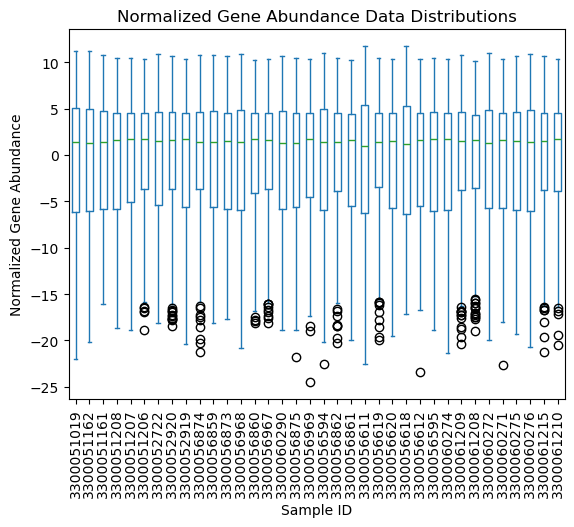

In [8]:
# Visualize data after clr normalization
norm_data.plot(kind='box')
plt.xticks(rotation=90)
plt.xlabel('Sample ID')
plt.ylabel('Normalized Gene Abundance')
plt.title('Normalized Gene Abundance Data Distributions')
plt.show()

The CLR normalization creates a more consistent and "normal" data distribution across samples

## Test for differences in KO abundance across seasons and depths

In [9]:
#Sort based on IDs to make sure samples and metadata are lined up
metadata = metadata.sort_index()
norm_data = norm_data.T.sort_index()

if list(norm_data.index) != list(metadata.index):
    print('samples not aligned!')

In [10]:
# Loop through KOs and compute stats for each
season_pvals = []
season_top_pvals = []
season_mid_pvals = []
season_btm_pvals = []
depth_pvals = []
depth_r = []
depth_r_p = []
for order in norm_data.columns:
    season_temp = stats.kruskal(norm_data[metadata.month == 'Oct'][order], 
                                norm_data[metadata.month == 'Feb'][order], 
                                norm_data[metadata.month == 'May'][order], 
                                norm_data[metadata.month == 'Aug'][order]).pvalue
    season_top_temp = stats.kruskal(norm_data[(metadata.month == 'Oct')&(metadata.depth=='Top')][order], 
                                norm_data[(metadata.month == 'Feb')&(metadata.depth=='Top')][order], 
                                norm_data[(metadata.month == 'May')&(metadata.depth=='Top')][order], 
                                norm_data[(metadata.month == 'Aug')&(metadata.depth=='Top')][order]).pvalue
    season_mid_temp = stats.kruskal(norm_data[(metadata.month == 'Oct')&(metadata.depth=='Mid')][order], 
                                norm_data[(metadata.month == 'Feb')&(metadata.depth=='Mid')][order], 
                                norm_data[(metadata.month == 'May')&(metadata.depth=='Mid')][order], 
                                norm_data[(metadata.month == 'Aug')&(metadata.depth=='Mid')][order]).pvalue
    season_btm_temp = stats.kruskal(norm_data[(metadata.month == 'Oct')&(metadata.depth=='Btm')][order], 
                                norm_data[(metadata.month == 'Feb')&(metadata.depth=='Btm')][order], 
                                norm_data[(metadata.month == 'May')&(metadata.depth=='Btm')][order], 
                                norm_data[(metadata.month == 'Aug')&(metadata.depth=='Btm')][order]).pvalue
    depth_temp = stats.kruskal(norm_data[metadata.depth == 'Btm'][order], 
                                norm_data[metadata.depth == 'Mid'][order], 
                                norm_data[metadata.depth == 'Top'][order]).pvalue
    depth_spearman = stats.spearmanr(metadata.depth_cm, norm_data[order], alternative = 'two-sided')
    season_pvals.append(season_temp)
    season_top_pvals.append(season_top_temp)
    season_mid_pvals.append(season_mid_temp)
    season_btm_pvals.append(season_btm_temp)
    depth_pvals.append(depth_temp)
    depth_r.append(depth_spearman.correlation)
    depth_r_p.append(depth_spearman.pvalue)

0
1
2
3
4
5
6
7
8
9


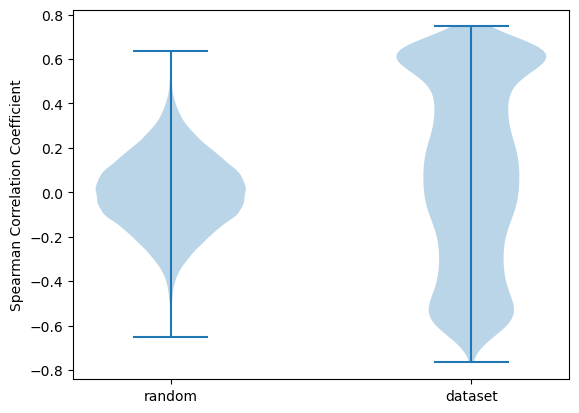

In [11]:
# Permutation test for Spearman correlation
# i.e. randomly permute depth label and compute Spearman correlation to get a null distribution
from random import sample
random_r = []
for j in range(10):
    print(j)
    for i in norm_data.columns:
        random_depths = sample(list(metadata.depth_cm.astype(int)), len(metadata.depth_cm))
        random_r.append(stats.spearmanr(random_depths, norm_data[i], alternative = 'two-sided').correlation)

# Plot null distribution next to actual dataset distribution of Spearman correlation coefficients
plt.violinplot([random_r, depth_r])
plt.xticks([1,2],['random', 'dataset'])
plt.ylabel('Spearman Correlation Coefficient')
plt.show()

In [12]:
# Print statistics related to null distribution
from scipy.stats import normaltest, norm
mu = np.mean(random_r)
sigma = np.std(random_r)
print(normaltest(random_r))
print("mean = " + str(mu))
print("std = " + str(sigma))

NormaltestResult(statistic=np.float64(46.453584115352434), pvalue=np.float64(8.17960585328102e-11))
mean = -0.00021290712171623323
std = 0.169345778021856


In [13]:
# Compute probability of actual dataset r values using the random null distribution
z_scores = []
p_vals = []
for i in depth_r:
    z = (i - mu)/sigma
    z_scores.append(z)
    p = norm.sf(abs(z))*2
    p_vals.append(p)

In [14]:
#Add Benjamini-Hochberg p-value correction for multiple testing
kruskal_res = pd.DataFrame({'season_pval':season_pvals, 'depth_pval':depth_pvals, 'spearman_r':depth_r, 'spearman_p':depth_r_p}, index=norm_data.columns)
kruskal_res['season_pval_corr'] = fdrcorrection(kruskal_res['season_pval'], alpha=0.05)[1]
kruskal_res['depth_pval_corr'] = fdrcorrection(kruskal_res['depth_pval'], alpha=0.05)[1]
kruskal_res['spearman_p'] = p_vals
kruskal_res['spearman_pval_corr'] = fdrcorrection(p_vals, alpha=0.05)[1]
kruskal_res.head()

,,season_pval,depth_pval,spearman_r,spearman_p,season_pval_corr,depth_pval_corr,spearman_pval_corr
Function ID,Function Name,,,,,,,
KO:K00001,alcohol dehydrogenase [EC:1.1.1.1],0.942835,0.002108,0.589483,0.000497,0.999819,0.009443,0.002314
KO:K00002,alcohol dehydrogenase (NADP+) [EC:1.1.1.2],0.688174,0.778801,-0.108072,0.524180,0.999819,0.837342,0.627100
KO:K00003,homoserine dehydrogenase [EC:1.1.1.3],0.939539,0.000625,0.648431,0.000128,0.999819,0.007151,0.001617
KO:K00004,"(R,R)-butanediol dehydrogenase / meso-butanediol dehydrogenase / diacetyl reductase [EC:1.1.1.4 1.1.1.- 1.1.1.303]",0.608682,0.000989,0.628782,0.000204,0.999819,0.007176,0.001617
KO:K00005,glycerol dehydrogenase [EC:1.1.1.6],0.985633,0.001812,0.599308,0.000400,0.999819,0.008842,0.002080


In [15]:
#Add Benjamini-Hochberg p-value correction for multiple testing
kruskal_res = pd.DataFrame({'season_pval':season_pvals, 'season_top_pval':season_top_pvals, 'season_mid_pval':season_mid_pvals, 'season_btm_pval':season_btm_pvals,
                            'depth_pval':depth_pvals, 'spearman_r':depth_r, 'spearman_p':p_vals}, index=norm_data.columns)
kruskal_res['season_pval_corr'] = fdrcorrection(kruskal_res['season_pval'], alpha=0.05)[1]
kruskal_res['season_top_pval_corr'] = fdrcorrection(kruskal_res['season_top_pval'], alpha=0.05)[1]
kruskal_res['season_mid_pval_corr'] = fdrcorrection(kruskal_res['season_mid_pval'], alpha=0.05)[1]
kruskal_res['season_btm_pval_corr'] = fdrcorrection(kruskal_res['season_btm_pval'], alpha=0.05)[1]
kruskal_res['depth_pval_corr'] = fdrcorrection(kruskal_res['depth_pval'], alpha=0.05)[1]
kruskal_res['spearman_pval_corr'] = fdrcorrection(kruskal_res['spearman_p'], alpha=0.05)[1]
kruskal_res.head()

,,season_pval,season_top_pval,season_mid_pval,season_btm_pval,depth_pval,spearman_r,spearman_p,season_pval_corr,season_top_pval_corr,season_mid_pval_corr,season_btm_pval_corr,depth_pval_corr,spearman_pval_corr
Function ID,Function Name,,,,,,,,,,,,,
KO:K00001,alcohol dehydrogenase [EC:1.1.1.1],0.942835,0.515968,0.862906,0.129003,0.002108,0.589483,0.000497,0.999819,0.986305,0.998161,0.409148,0.009443,0.002314
KO:K00002,alcohol dehydrogenase (NADP+) [EC:1.1.1.2],0.688174,0.577746,0.932731,0.826047,0.778801,-0.108072,0.524180,0.999819,0.986305,0.998161,0.884206,0.837342,0.627100
KO:K00003,homoserine dehydrogenase [EC:1.1.1.3],0.939539,0.886980,0.972476,0.147321,0.000625,0.648431,0.000128,0.999819,0.986305,0.998161,0.409148,0.007151,0.001617
KO:K00004,"(R,R)-butanediol dehydrogenase / meso-butanediol dehydrogenase / diacetyl reductase [EC:1.1.1.4 1.1.1.- 1.1.1.303]",0.608682,0.588525,0.972476,0.075240,0.000989,0.628782,0.000204,0.999819,0.986305,0.998161,0.409148,0.007176,0.001617
KO:K00005,glycerol dehydrogenase [EC:1.1.1.6],0.985633,0.910364,0.838399,0.459290,0.001812,0.599308,0.000400,0.999819,0.986305,0.998161,0.620417,0.008842,0.002080


In [16]:
kruskal_res.sort_values('spearman_r').head(20)

,,season_pval,season_top_pval,season_mid_pval,season_btm_pval,depth_pval,spearman_r,spearman_p,season_pval_corr,season_top_pval_corr,season_mid_pval_corr,season_btm_pval_corr,depth_pval_corr,spearman_pval_corr
Function ID,Function Name,,,,,,,,,,,,,
KO:K20158,pseudooxynicotine oxidase [EC:1.4.3.24],0.968920,0.131898,0.062711,0.826047,0.000027,-0.766328,0.000006,0.999819,0.986305,0.998161,0.884206,0.007151,0.001617
KO:K22797,diglucosylglycerate octanoyltransferase [EC:2.3.1.273],0.903362,0.972476,0.679315,0.515968,0.000077,-0.733579,0.000015,0.999819,0.992481,0.998161,0.665870,0.007151,0.001617
KO:K20529,type IV secretion system protein TrbD,0.598350,0.577746,0.679315,0.376081,0.000113,-0.720479,0.000021,0.999819,0.986305,0.998161,0.557292,0.007151,0.001617
KO:K00222,Delta14-sterol reductase [EC:1.3.1.70],0.557787,0.838399,0.100907,0.441536,0.000217,-0.694280,0.000042,0.999819,0.986305,0.998161,0.610342,0.007151,0.001617
KO:K07239,"heavy-metal exporter, HME family",0.515731,0.432870,0.788846,0.191565,0.000240,-0.687730,0.000049,0.999819,0.986305,0.998161,0.426642,0.007151,0.001617
KO:K01236,maltooligosyltrehalose trehalohydrolase [EC:3.2.1.141],0.708729,0.134854,0.556595,0.200051,0.000271,-0.684455,0.000053,0.999819,0.986305,0.998161,0.426642,0.007151,0.001617
KO:K20118,glucose PTS system EIICBA or EIICB component [EC:2.7.1.199],0.858590,0.556595,0.963368,0.247949,0.000275,-0.684455,0.000053,0.999819,0.986305,0.998161,0.454525,0.007151,0.001617
KO:K22350,manganese oxidase [EC:1.16.3.3],0.585176,0.086190,0.862906,0.103197,0.000167,-0.681180,0.000058,0.999819,0.986305,0.998161,0.409148,0.007151,0.001617
KO:K11746,glutathione-regulated potassium-efflux system ancillary protein KefF,0.858113,0.788846,0.921699,0.147321,0.000287,-0.681180,0.000058,0.999819,0.986305,0.998161,0.409148,0.007151,0.001617


In [17]:
kruskal_res.sort_values('spearman_r', ascending=False).head(20)

,,season_pval,season_top_pval,season_mid_pval,season_btm_pval,depth_pval,spearman_r,spearman_p,season_pval_corr,season_top_pval_corr,season_mid_pval_corr,season_btm_pval_corr,depth_pval_corr,spearman_pval_corr
Function ID,Function Name,,,,,,,,,,,,,
KO:K22477,N-acetylglutamate synthase [EC:2.3.1.1],0.929848,0.953642,0.556595,0.129003,0.000057,0.746679,0.000010,0.999819,0.992481,0.998161,0.409148,0.007151,0.001617
KO:K00757,uridine phosphorylase [EC:2.4.2.3],0.967856,0.407710,0.910364,0.140957,0.000088,0.730304,0.000016,0.999819,0.986305,0.998161,0.409148,0.007151,0.001617
KO:K22958,gallate decarboxylase subunit C [EC:4.1.1.59],0.634555,0.764094,0.788846,0.076966,0.000123,0.717204,0.000023,0.999819,0.986305,0.998161,0.409148,0.007151,0.001617
KO:K10440,ribose transport system permease protein,0.981799,0.739509,0.963368,0.281509,0.000112,0.717204,0.000023,0.999819,0.986305,0.998161,0.477851,0.007151,0.001617
KO:K01250,pyrimidine-specific ribonucleoside hydrolase [EC:3.2.-.-],0.421559,0.123394,0.131898,0.361067,0.000129,0.713930,0.000025,0.999819,0.986305,0.998161,0.543677,0.007151,0.001617
KO:K02884,large subunit ribosomal protein L19,0.932405,0.764094,0.667556,0.140957,0.000081,0.713930,0.000025,0.999819,0.986305,0.998161,0.409148,0.007151,0.001617
KO:K13722,tricorn protease interacting factor F2/3 [EC:3.4.11.-],0.824969,0.739509,0.788846,0.269891,0.000133,0.713930,0.000025,0.999819,0.986305,0.998161,0.472247,0.007151,0.001617
KO:K05896,segregation and condensation protein A,0.988126,0.739509,0.515968,0.147321,0.000131,0.713930,0.000025,0.999819,0.986305,0.998161,0.409148,0.007151,0.001617
KO:K09807,uncharacterized protein,0.922941,0.715179,0.441536,0.264246,0.000133,0.713930,0.000025,0.999819,0.986305,0.998161,0.472247,0.007151,0.001617


In [18]:
print('Number of orders significantly different by season: ' + str(np.sum(kruskal_res['season_pval_corr'] < 0.05)))
print('Number of orders significantly different by season (Top only): ' + str(np.sum(kruskal_res['season_top_pval_corr'] < 0.05)))
print('Number of orders significantly different by season (Mid only): ' + str(np.sum(kruskal_res['season_mid_pval_corr'] < 0.05)))
print('Number of orders significantly different by season (Bottom only): ' + str(np.sum(kruskal_res['season_btm_pval_corr'] < 0.05)))
print('Number of orders significantly different by depth: ' + str(np.sum(kruskal_res['depth_pval_corr'] < 0.05)))
print('Number of order significantly correlated by depth: ' + str(np.sum(kruskal_res['spearman_pval_corr'] < 0.05)))

Number of orders significantly different by season: 0
Number of orders significantly different by season (Top only): 0
Number of orders significantly different by season (Mid only): 0
Number of orders significantly different by season (Bottom only): 0
Number of orders significantly different by depth: 4101
Number of order significantly correlated by depth: 4759


In [19]:
print('Number of order significantly positively correlated by depth: ' + str(np.sum((kruskal_res['spearman_pval_corr'] < 0.05)&(kruskal_res['spearman_r']>0))))
print('Number of order significantly negatively correlated by depth: ' + str(np.sum((kruskal_res['spearman_pval_corr'] < 0.05)&(kruskal_res['spearman_r']<0))))

Number of order significantly positively correlated by depth: 3020
Number of order significantly negatively correlated by depth: 1739


In [20]:
sig_genes = kruskal_res[kruskal_res['spearman_pval_corr']<0.05].sort_values('spearman_r')

In [21]:
plot_df = norm_data.copy()
plot_df['depth'] = metadata.depth
plot_df['month'] = metadata.month
plot_df

Function ID,KO:K00001,KO:K00002,KO:K00003,KO:K00004,KO:K00005,KO:K00006,KO:K00007,KO:K00008,KO:K00009,KO:K00010,...,KO:K24843,KO:K24844,KO:K24845,KO:K24846,KO:K24847,KO:K24850,KO:K24854,KO:K24865,depth,month
Function Name,alcohol dehydrogenase [EC:1.1.1.1],alcohol dehydrogenase (NADP+) [EC:1.1.1.2],homoserine dehydrogenase [EC:1.1.1.3],"(R,R)-butanediol dehydrogenase / meso-butanediol dehydrogenase / diacetyl reductase [EC:1.1.1.4 1.1.1.- 1.1.1.303]",glycerol dehydrogenase [EC:1.1.1.6],glycerol-3-phosphate dehydrogenase (NAD+) [EC:1.1.1.8],D-arabinitol 4-dehydrogenase [EC:1.1.1.11],L-iditol 2-dehydrogenase [EC:1.1.1.14],mannitol-1-phosphate 5-dehydrogenase [EC:1.1.1.17],myo-inositol 2-dehydrogenase / D-chiro-inositol 1-dehydrogenase [EC:1.1.1.18 1.1.1.369],...,O2-independent ubiquinone biosynthesis accessory factor UbiT,O2-independent ubiquinone biosynthesis protein UbiU,O2-independent ubiquinone biosynthesis protein UbiV,"ATP-binding cassette, subfamily B, bacterial PglK [EC:7.5.2.-]",23S rRNA 5-hydroxycytidine C2501 synthase,interferon-induced protein with tetratricopeptide repeats 5,"damage-control phosphatase, subfamily II, stand-alone protein [EC:3.1.3.-]",CDAN1-interacting nuclease 1,,
3300051019,5.157988,3.047338,8.102030,5.753507,4.983559,-11.513736,-7.437701,9.028521,4.516900,8.006666,...,0.745018,0.992672,1.309461,1.470578,3.294928,-9.490633,-1.579042,0.537574,Btm,Oct
3300051161,5.313193,2.759021,7.649192,5.259439,4.468940,-7.179610,-1.048858,8.112701,3.746412,7.142735,...,1.704164,2.598266,2.694652,-1.437132,2.523397,-9.383551,-5.583311,-6.243622,Top,Oct
3300051162,5.320007,2.607653,7.902062,5.575878,4.520707,-6.762955,-2.782339,8.761188,4.412287,7.855241,...,0.388861,1.418339,0.677900,0.975900,2.996057,-7.924360,-4.119790,-0.863398,Mid,Oct
3300051206,4.507250,2.167904,7.012055,3.652555,2.971075,-8.188211,1.247406,6.533540,1.513236,6.742420,...,3.289476,3.845080,3.755451,2.256485,4.126559,-3.536557,-7.371762,-9.794626,Top,Oct
3300051207,4.680192,2.373437,7.135915,3.894369,3.276569,-8.044680,1.482273,6.905014,2.230022,6.611856,...,2.946345,3.608107,3.420690,2.031283,3.645635,-5.498072,-9.017342,-2.876213,Mid,Oct
3300051208,4.928813,1.819103,7.257803,3.998206,3.429950,-8.173683,0.573940,7.178722,2.678568,6.639158,...,3.112652,3.916321,3.576849,1.527236,3.618599,-7.163879,-8.154991,-9.148605,Btm,Oct
3300052722,5.182109,2.111675,7.483211,5.076925,4.504371,-8.195651,-2.802181,8.112986,4.076364,7.253930,...,1.761223,2.838993,2.757975,0.672893,3.246379,-7.473239,-7.999076,-8.584414,Btm,Oct
3300052919,4.637080,2.249068,7.308101,3.955808,3.654898,-10.474051,0.773004,6.842790,2.371800,6.868869,...,3.187386,4.193810,3.816041,1.797823,4.617792,-10.563280,-6.040583,-1.813251,Top,Oct
3300052920,5.077986,1.745313,7.374967,4.705156,4.389076,-8.408611,-1.820519,7.742175,3.636149,6.998454,...,2.398461,3.042852,2.481016,0.444791,3.322102,-10.023254,-8.767995,-1.144187,Mid,Oct


In [22]:
sig_genes.to_csv('output/depth_correlated_genes.csv')

In [23]:
sig_genes.head()

,,season_pval,season_top_pval,season_mid_pval,season_btm_pval,depth_pval,spearman_r,spearman_p,season_pval_corr,season_top_pval_corr,season_mid_pval_corr,season_btm_pval_corr,depth_pval_corr,spearman_pval_corr
Function ID,Function Name,,,,,,,,,,,,,
KO:K20158,pseudooxynicotine oxidase [EC:1.4.3.24],0.968920,0.131898,0.062711,0.826047,0.000027,-0.766328,0.000006,0.999819,0.986305,0.998161,0.884206,0.007151,0.001617
KO:K22797,diglucosylglycerate octanoyltransferase [EC:2.3.1.273],0.903362,0.972476,0.679315,0.515968,0.000077,-0.733579,0.000015,0.999819,0.992481,0.998161,0.665870,0.007151,0.001617
KO:K20529,type IV secretion system protein TrbD,0.598350,0.577746,0.679315,0.376081,0.000113,-0.720479,0.000021,0.999819,0.986305,0.998161,0.557292,0.007151,0.001617
KO:K00222,Delta14-sterol reductase [EC:1.3.1.70],0.557787,0.838399,0.100907,0.441536,0.000217,-0.694280,0.000042,0.999819,0.986305,0.998161,0.610342,0.007151,0.001617
KO:K07239,"heavy-metal exporter, HME family",0.515731,0.432870,0.788846,0.191565,0.000240,-0.687730,0.000049,0.999819,0.986305,0.998161,0.426642,0.007151,0.001617


/tmp/ipykernel_5704/2732492172.py:20: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


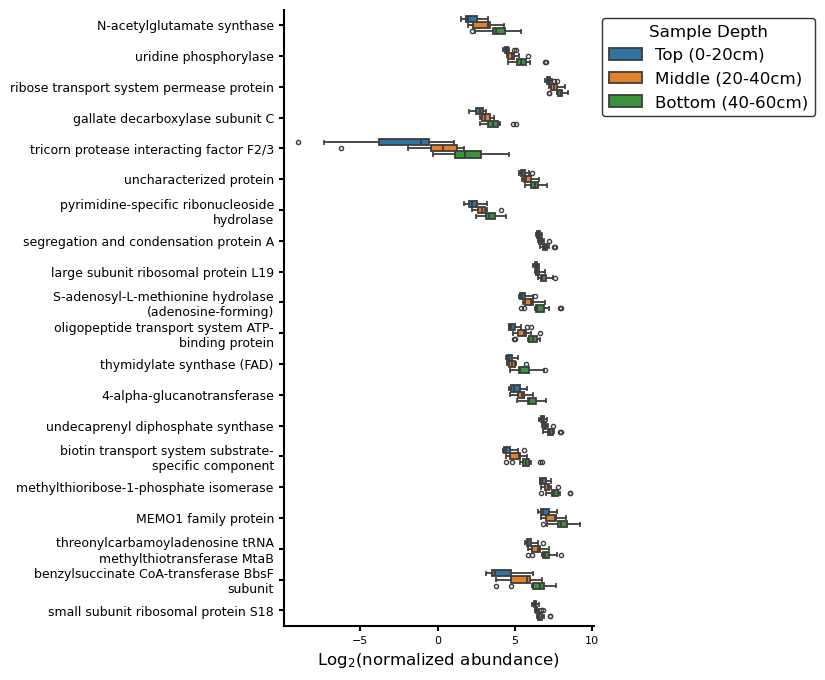

In [24]:
# Plot most positively correlated KOs
genes = list(sig_genes[sig_genes.spearman_r > 0.].sort_values('spearman_p').head(20).index)
df = plot_df.melt(id_vars=[('month',''), ('depth', '')], value_vars=genes)
df.rename({('month',''):'month', ('depth',''):'depth'}, axis=1, inplace=True) 

fig, ax = plt.subplots(1,1, figsize=(4, 8))
g = sns.boxplot(data=df, y='Function ID', x='value', hue='depth', dodge=True, width=.6, fliersize=3, linewidth=1.3, hue_order=['Top','Mid','Btm'])
sns.despine()
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.tick_params(width=1.5)

labels = ['\n'.join(wrap(x[1].split('[')[0], 40)) for x in  genes]
plt.yticks(np.arange(0,20), labels, fontsize=9, rotation=0)

plt.xticks(fontsize=8)
plt.xlabel('Log$_2$(normalized abundance)', size=12)
plt.ylabel('')
ax.legend(handles = ax.get_legend_handles_labels()[0], title='Sample Depth', labels=['Top (0-20cm)', 'Middle (20-40cm)', 'Bottom (40-60cm)'],
          fontsize=12, title_fontsize=12, edgecolor='black', bbox_to_anchor=(1.,1.))
plt.tight_layout()
#plt.savefig('figures/order_rel_abun_depth_top20.png', dpi=450)
plt.show()

/tmp/ipykernel_5704/3397812655.py:20: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


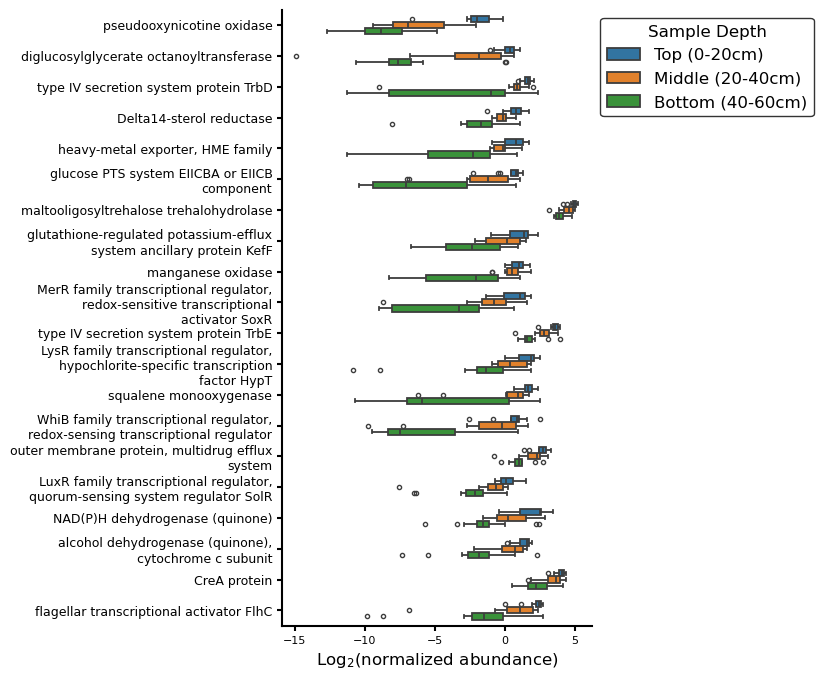

In [25]:
# Plot most negatively correlated KOs
genes = list(sig_genes[sig_genes.spearman_r < 0.].sort_values('spearman_p').head(20).index)
df = plot_df.melt(id_vars=[('month',''), ('depth', '')], value_vars=genes)
df.rename({('month',''):'month', ('depth',''):'depth'}, axis=1, inplace=True) 

fig, ax = plt.subplots(1,1, figsize=(4, 8))
g = sns.boxplot(data=df, y='Function ID', x='value', hue='depth', dodge=True, width=.6, fliersize=3, linewidth=1.3, hue_order=['Top','Mid','Btm'])
sns.despine()
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.tick_params(width=1.5)

labels = ['\n'.join(wrap(x[1].split('[')[0], 40)) for x in  genes]
plt.yticks(np.arange(0,20), labels, fontsize=9, rotation=0)

plt.xticks(fontsize=8)
plt.xlabel('Log$_2$(normalized abundance)', size=12)
plt.ylabel('')
ax.legend(handles = ax.get_legend_handles_labels()[0], title='Sample Depth', labels=['Top (0-20cm)', 'Middle (20-40cm)', 'Bottom (40-60cm)'],
          fontsize=12, title_fontsize=12, edgecolor='black', bbox_to_anchor=(1.,1.))
plt.tight_layout()
#plt.savefig('figures/order_rel_abun_depth_top20.png', dpi=450)
plt.show()

## Perform distance-based analysis on the KO abundance data

In [26]:
dist = pdist(norm_data, metric='Euclidean')
square_dist = squareform(dist)
dist_mat = distance.DistanceMatrix(square_dist, ids=norm_data.index)

In [27]:
distance.permanova(dist_mat, metadata.depth, permutations=99999)

method name               PERMANOVA
test statistic name        pseudo-F
sample size                      36
number of groups                  3
test statistic             2.633588
p-value                     0.00026
number of permutations        99999
Name: PERMANOVA results, dtype: object

In [28]:
distance.permanova(dist_mat, metadata.month, permutations=9999)

method name               PERMANOVA
test statistic name        pseudo-F
sample size                      36
number of groups                  4
test statistic             1.020007
p-value                      0.3646
number of permutations         9999
Name: PERMANOVA results, dtype: object

In [29]:
distance.anosim(dist_mat, metadata.depth, permutations=99999)

method name                 ANOSIM
test statistic name              R
sample size                     36
number of groups                 3
test statistic            0.228746
p-value                    0.00058
number of permutations       99999
Name: ANOSIM results, dtype: object

In [30]:
distance.anosim(dist_mat, metadata.month, permutations=9999)

method name                 ANOSIM
test statistic name              R
sample size                     36
number of groups                 4
test statistic            0.003829
p-value                      0.383
number of permutations        9999
Name: ANOSIM results, dtype: object

* Based on both permanova and anosim tests, we find significant differences in functional gene composition based on sample depth (p < 0.001) but not based on season.

/mnt/c/Users/Zach_Flinkstrom/Documents/ubuntu/.conda/envs/wetland_study/lib/python3.12/site-packages/skbio/util/_plotting.py:53: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout()
/mnt/c/Users/Zach_Flinkstrom/Documents/ubuntu/.conda/envs/wetland_study/lib/python3.12/site-packages/skbio/util/_plotting.py:53: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout()


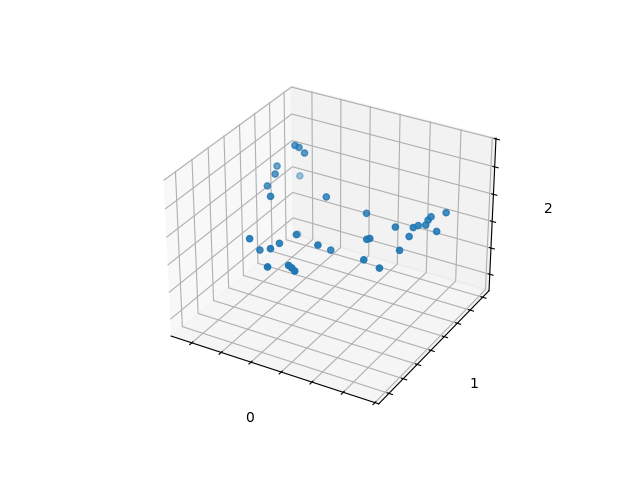

In [31]:
pcoa = ordination.pcoa(dist_mat)
pcoa

In [32]:
pcoa_plot = pcoa.samples.copy()
pcoa_plot['depth'] = list(metadata.depth)
pcoa_plot['month'] = list(metadata.month)

In [33]:
def confidence_ellipse(x, y, ax, n_std=1.5, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensional dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the standard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the standard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

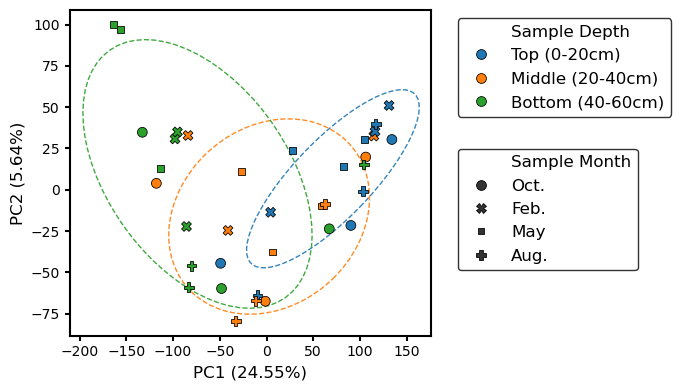

In [34]:
# Plot PCoA of KO abundance colored by depth
fig, ax = plt.subplots(1,1, figsize=(7, 4))

confidence_ellipse(pcoa_plot[pcoa_plot.depth=='Top']['PC1'], pcoa_plot[pcoa_plot.depth=='Top']['PC2'], ax, edgecolor='tab:blue', linestyle='--', alpha=0.9)
confidence_ellipse(pcoa_plot[pcoa_plot.depth=='Mid']['PC1'], pcoa_plot[pcoa_plot.depth=='Mid']['PC2'], ax, edgecolor='tab:orange', linestyle='--', alpha=0.9)
confidence_ellipse(pcoa_plot[pcoa_plot.depth=='Btm']['PC1'], pcoa_plot[pcoa_plot.depth=='Btm']['PC2'], ax, edgecolor='tab:green', linestyle='--', alpha=0.9)
sns.scatterplot(data=pcoa_plot, x='PC1', y='PC2', hue='depth', style='month', s=50, edgecolor='black', hue_order=['Top','Mid','Btm'], 
                style_order=['Oct','Feb','May','Aug'], ax=ax)

ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['top'].set_linewidth(1.5)
ax.spines['right'].set_linewidth(1.5)

first_legend = ax.legend(handles = ax.get_legend_handles_labels()[0][4:], 
          labels=['Sample Month', 'Oct.', 'Feb.', 'May', 'Aug.'],
          fontsize=12, title_fontsize=12, edgecolor='black', bbox_to_anchor=(1.05, .6))
ax.add_artist(first_legend)
ax.legend(handles = ax.get_legend_handles_labels()[0][0:4], 
          labels=["Sample Depth", 'Top (0-20cm)', 'Middle (20-40cm)', 'Bottom (40-60cm)'],
          fontsize=12, title_fontsize=12, edgecolor='black', bbox_to_anchor=(1.05, 1.0))

ax.tick_params(width=1.5)
plt.xticks(size=10)
plt.yticks(fontsize=10)
plt.xlabel('PC1 ({:.2f}%)'.format(pcoa.proportion_explained.iloc[0]*100), size=12)
plt.ylabel('PC2 ({:.2f}%)'.format(pcoa.proportion_explained.iloc[1]*100), size=12)
plt.tight_layout()
plt.savefig('figures/ko_pcoa.png', dpi=450)
plt.show()

## Compare functional diversity across depths

In [35]:
shannon = diversity.alpha_diversity('shannon', data.T.sort_index(), base=2, ids = data.T.sort_index().index)
plot_df['shannon'] = shannon

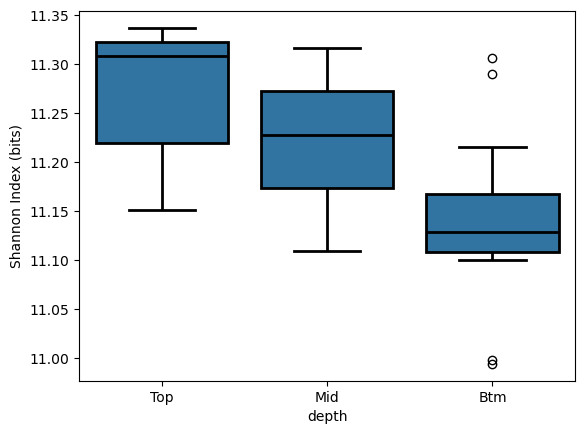

In [36]:
sns.boxplot(data=plot_df, x='depth', y='shannon', linewidth=2., linecolor='black', order=['Top','Mid','Btm'])
plt.ylabel('Shannon Index (bits)')
plt.savefig('figures/MG_kos_shannon_depth.png', dpi=450)
plt.show()

In [37]:
# Compute kruskal stat for Shannon index across seasons
stats.kruskal(plot_df[plot_df.month=='Oct'].shannon, plot_df[plot_df.month=='Feb'].shannon, plot_df[plot_df.month=='May'].shannon, plot_df[plot_df.month=='Aug'].shannon)

KruskalResult(statistic=np.float64(1.7467467467467657), pvalue=np.float64(0.626591416418729))

In [38]:
# Compute kruskal stat for Shannon index across depths
stats.kruskal(plot_df[plot_df.depth=='Top'].shannon, plot_df[plot_df.depth=='Mid'].shannon, plot_df[plot_df.depth=='Btm'].shannon)

KruskalResult(statistic=np.float64(12.902402402402402), pvalue=np.float64(0.001578624783407517))

In [39]:
# Compute post-hoc Dunn's analysis for Shannon index across depths
posthoc_dunn([plot_df[plot_df.depth=='Top'].shannon, plot_df[plot_df.depth=='Mid'].shannon, plot_df[plot_df.depth=='Btm'].shannon])

,1,2,3
1,1.000000,0.112124,0.000338
2,0.112124,1.000000,0.045979
3,0.000338,0.045979,1.000000


**Bottom soil section has significantly lower functional diversity compared to Top (p < 0.001) and Middle (p < 0.05) sections**

## Perform analysis based on KEGG Module abundance

In [40]:

# Base URL for KEGG API
KEGG_API_BASE = "http://rest.kegg.jp"

def get_kegg_modules():
    """
    Retrieve the list of KEGG modules
    :return: A list of KEGG module identifiers (e.g., M00001, M00002, etc.)
    """
    url = f"{KEGG_API_BASE}/list/module"
    response = requests.get(url)
    
    if response.status_code == 200:
        modules = response.text.strip().split("\n")
        module_ids = [line.split("\t")[0] for line in modules]
        return module_ids
    else:
        raise Exception(f"Failed to retrieve KEGG modules. Status code: {response.status_code}")

def get_module_details(module_id):
    """
    Retrieve details of a specific KEGG module, including the name and associated KEGG orthologs with names
    :param module_id: The KEGG module identifier (e.g., M00001)
    :return: A dictionary with module name and a list of orthologs with their names
    """
    url = f"{KEGG_API_BASE}/get/{module_id}"
    response = requests.get(url)
    
    if response.status_code == 200:
        module_data = response.text
        module_name = ""
        orthologs = []
        in_ortholog_section = False

         # Parse the module details to extract the module name and orthologs
        for line in module_data.split("\n"):
            if line.startswith("NAME"):
                module_name = line.split("NAME")[1].strip()
            elif line.startswith("ORTHOLOGY"):
                in_ortholog_section = True
                parts = line.strip().split("  ", 2)
                if len(parts) == 3:
                    ortholog_id = parts[1].strip()
                    ortholog_name = parts[2].strip()
                    orthologs.append((ortholog_id, ortholog_name))
            elif in_ortholog_section and line.startswith(" "):
                # Extract KEGG ortholog ID and name
                parts = line.strip().split("  ", 1)
                if len(parts) == 2:
                    ortholog_id = parts[0].strip()
                    ortholog_name = parts[1].strip()
                    orthologs.append((ortholog_id, ortholog_name))
            elif in_ortholog_section and not line.startswith(" "):
                break  # Exit once the orthology section ends
        
        return {
            "module_id": module_id, 
            "module_name": module_name, 
            "orthologs": orthologs
        }
    else:
        raise Exception(f"Failed to retrieve details for module {module_id}. Status code: {response.status_code}")

def main():
    # Get the list of KEGG modules
    print("Fetching KEGG modules...")
    modules = get_kegg_modules()
    print(f"Found {len(modules)} modules.")
    
    # Retrieve orthologs and names for each module
    kegg_data = []
    for module_id in modules[:10]:  # Limiting to first 10 modules for demo purposes
        print(f"Fetching details for module {module_id}...")
        module_info = get_module_details(module_id)
        kegg_data.append(module_info)
    
    # Print the results
    for module in kegg_data:
        print(f"Module: {module['module_id']} - {module['module_name']}")
        print("Orthologs:")
        for ortholog_id, ortholog_name in module['orthologs']:
            print(f"  {ortholog_id}: {ortholog_name}")
        print()

if __name__ == "__main__":
    main()


Fetching KEGG modules...
Found 513 modules.
Fetching details for module M00001...
Fetching details for module M00002...
Fetching details for module M00003...
Fetching details for module M00004...
Fetching details for module M00005...
Fetching details for module M00006...
Fetching details for module M00007...
Fetching details for module M00008...
Fetching details for module M00009...
Fetching details for module M00010...
Module: M00001 - Glycolysis (Embden-Meyerhof pathway), glucose => pyruvate
Orthologs:
  K00844,K12407,K00845,K25026: hexokinase/glucokinase [EC:2.7.1.1 2.7.1.2] [RN:R01786]
  K00886: polyphosphate glucokinase [EC:2.7.1.63] [RN:R02189]
  K08074,K00918: ADP-dependent glucokinase [EC:2.7.1.147] [RN:R09085]
  K01810,K06859,K13810,K15916: glucose-6-phosphate isomerase [EC:5.3.1.9] [RN:R13199]
  K00850,K16370,K21071,K24182: 6-phosphofructokinase [EC:2.7.1.11] [RN:R00756]
  K00918: ADP-dependent phosphofructokinase [EC:2.7.1.146] [RN:R05805]
  K01623,K01624,K11645,K16305,K1630

In [41]:
# Base URL for KEGG API
KEGG_API_BASE = "http://rest.kegg.jp"

def get_modules_for_ko(ko_id):
    """
    Retrieve the list of KEGG modules associated with a specific KEGG Ortholog (KO) ID
    :param ko_id: The KEGG KO identifier (e.g., K00844)
    :return: A list of KEGG module IDs and their names associated with the given KO
    """
    url = f"{KEGG_API_BASE}/link/module/{ko_id}"
    response = requests.get(url)
    
    if response.status_code == 200:
        module_links = response.text.strip().split("\n")
        modules = []
        
        # Parse the response to extract module IDs
        for line in module_links:
            parts = line.split("\t")
            if len(parts) == 2:
                module_id = parts[1].replace("md:", "")  # Module ID (e.g., M00001)
                modules.append(module_id)
        
        # Fetch module names for each module
        module_details = []
        for module_id in modules:
            module_info = get_module_name(module_id)
            if module_info:
                module_details.append(module_info)
        
        return module_details
    else:
        raise Exception(f"Failed to retrieve modules for KO {ko_id}. Status code: {response.status_code}")

def get_module_name(module_id):
    """
    Retrieve the name of a specific KEGG module
    :param module_id: The KEGG module identifier (e.g., M00001)
    :return: A tuple with the module ID and its name
    """
    url = f"{KEGG_API_BASE}/get/{module_id}"
    response = requests.get(url)
    
    if response.status_code == 200:
        module_data = response.text
        module_name = ""
        
        # Parse the module details to extract the module name
        for line in module_data.split("\n"):
            if line.startswith("NAME"):
                module_name = line.split("NAME")[1].strip()
                return (module_id, module_name)
        
        return (module_id, "Unknown")
    else:
        raise Exception(f"Failed to retrieve details for module {module_id}. Status code: {response.status_code}")

def main():
    ko_id = "K00844"  # Example KO ID
    print(f"Fetching KEGG modules associated with KO: {ko_id}")
    modules = get_modules_for_ko(ko_id)
    
    print(f"Modules associated with {ko_id}:")
    for module_id, module_name in modules:
        print(f"{module_id}: {module_name}")

if __name__ == "__main__":
    main()


Fetching KEGG modules associated with KO: K00844
Modules associated with K00844:
M00001: Glycolysis (Embden-Meyerhof pathway), glucose => pyruvate
M00549: UDP-Glc biosynthesis, Glc => UDP-Glc
M00892: UDP-GlcNAc biosynthesis, eukaryotes, Fru-6P => UDP-GlcNAc


In [42]:
# get mean abundance from every module (takes a while)
means = {}
modules = get_kegg_modules()
for mod in modules:
    module = get_module_details(mod)
    ko_list = [i[0] for i in module['orthologs']]
    new_list = []
    for i in ko_list:
        if len(i.split(',')) > 1:
            for j in i.split(','):
                new_list.append('KO:'+j)
        elif len(i.split('+')) > 1:
            for j in i.split('+'):
                new_list.append('KO:'+j)
        else:
            new_list.append('KO:'+i)
    to_filter = list(set(plot_df.columns.get_level_values(0)).intersection(set(new_list)))
    means[module['module_id']+module['module_name']] = plot_df[to_filter].mean(axis=1)

In [43]:
df = pd.DataFrame(means)
df['depth'] = plot_df['depth']
df['month'] = plot_df['month']
df = df.dropna(axis=1, how='any')
df

,"M00001Glycolysis (Embden-Meyerhof pathway), glucose => pyruvate","M00002Glycolysis, core module involving three-carbon compounds","M00003Gluconeogenesis, oxaloacetate => fructose-6P",M00004Pentose phosphate pathway (Pentose phosphate cycle),"M00005PRPP biosynthesis, ribose 5P => PRPP","M00006Pentose phosphate pathway, oxidative phase, glucose 6P => ribulose 5P","M00007Pentose phosphate pathway, non-oxidative phase, fructose 6P => ribose 5P","M00008Entner-Doudoroff pathway, glucose-6P => glyceraldehyde-3P + pyruvate","M00009Citrate cycle (TCA cycle, Krebs cycle)","M00010Citrate cycle, first carbon oxidation, oxaloacetate => 2-oxoglutarate",...,"M00997UDP-Xyl/L-Ara biosynthesis, UDP-Glc => UDP-Xyl => UDP-L-Ala","M00998UDP-L-Ara biosynthesis, L-Ala => UDP-L-Ala","M00999UDP-GlcA/GalA biosynthesis, UDP-Glc => UDP-GlcA => UDP-GalA","M01000GDP-Man biosynthesis, Fru-6P => GDP-Man","M01001GDP-L-Fuc biosynthesis, L-Fuc => GDP-L-Fuc","M01002UDP-GalNAc biosynthesis, Fru-6P => UDP-GalNAc","M01003UDP-GlcNAc biosynthesis, GlcNAc => UDP-GlcNAc","M01004UDP-Galf biosynthesis, UDP-Glc => UDP-Galf",depth,month
3300051019,6.074987,6.787197,5.864995,6.424392,8.200280,5.245023,7.436662,5.364170,4.723243,6.084755,...,4.065940,-3.265762,7.311094,5.477861,4.767522,8.153168,-1.873121,6.117680,Btm,Oct
3300051161,5.686886,6.483343,5.619526,6.102037,7.848293,5.250470,6.934284,5.522212,4.524916,5.959759,...,4.205064,-1.669695,6.886121,4.005320,4.121260,7.418098,-1.403427,5.209652,Top,Oct
3300051162,5.910459,6.661555,5.807194,6.303744,8.022206,5.142180,7.302559,5.477001,4.962095,6.070264,...,4.066711,-4.546313,7.205777,5.284062,4.510447,7.902063,0.857122,5.645960,Mid,Oct
3300051206,5.022278,5.923924,5.291386,5.597875,7.415706,5.122223,6.354039,5.626792,3.998302,5.821112,...,4.447635,-2.617750,6.741397,4.016921,2.838398,6.302178,-4.996249,5.344009,Top,Oct
3300051207,5.202157,5.977785,5.395937,5.627837,7.478875,5.074322,6.403200,5.722016,4.400315,5.878014,...,4.567537,-6.071884,6.663471,4.597835,2.785312,6.453674,-3.031602,5.045138,Mid,Oct
3300051208,5.338285,6.158657,5.459765,5.721390,7.485824,5.093556,6.490420,5.585493,4.711185,5.905807,...,4.478131,-5.265554,6.676552,4.502972,2.797940,6.665799,-2.531503,5.105370,Btm,Oct
3300052722,5.571605,6.343459,5.567115,5.963820,7.701465,5.026575,6.847560,5.596640,4.805697,5.855164,...,4.688181,-5.022997,6.918543,4.944257,4.070157,7.299832,-2.223464,5.447780,Btm,Oct
3300052919,5.272344,6.156661,5.362966,5.659922,7.479481,5.077882,6.432516,5.642796,4.797408,6.003213,...,4.534182,-6.168571,6.698252,4.525194,3.222318,6.521159,-2.939959,4.823538,Top,Oct
3300052920,5.534609,6.307118,5.508712,5.885340,7.569194,5.060698,6.704384,5.561820,4.479471,5.732668,...,4.536296,-3.805560,6.737950,4.818857,3.881660,7.117831,-2.950597,5.355121,Mid,Oct
3300056594,5.863218,6.596862,5.731697,6.109189,8.059530,4.785011,7.202801,5.111933,5.047397,6.112260,...,3.997872,-6.132206,7.187309,5.398223,4.047656,7.871195,-2.944607,5.718359,Btm,May


In [44]:
season_pvals = []
depth_pvals = []
depth_r = []
depth_r_p = []
for gene in df.columns:
    if (gene == 'month')|(gene == 'depth'):
        continue
    else:
        season_temp = stats.kruskal(df[df.month == 'Oct'][gene], 
                                    df[df.month == 'Feb'][gene], 
                                    df[df.month == 'May'][gene], 
                                    df[df.month == 'Aug'][gene]).pvalue
        depth_temp = stats.kruskal(df[df.depth == 'Btm'][gene], 
                                    df[df.depth == 'Mid'][gene], 
                                    df[df.depth == 'Top'][gene]).pvalue
        depth_spearman = stats.spearmanr(metadata.depth_cm, df[gene], alternative = 'two-sided')
        season_pvals.append(season_temp)
        depth_pvals.append(depth_temp)
        depth_r.append(depth_spearman.correlation)
        depth_r_p.append(depth_spearman.pvalue)

kruskal_res = pd.DataFrame({'season_pval':season_pvals, 'depth_pval':depth_pvals, 'spearman_r':depth_r, 'spearman_p':depth_r_p}, index=df.columns[0:-2])
kruskal_res['season_pval_corr'] = fdrcorrection(kruskal_res['season_pval'], alpha=0.05)[1]
kruskal_res['depth_pval_corr'] = fdrcorrection(kruskal_res['depth_pval'], alpha=0.05)[1]
kruskal_res['spearman_pval_corr'] = fdrcorrection(kruskal_res['spearman_p'], alpha=0.05)[1]
kruskal_res.head()

,season_pval,depth_pval,spearman_r,spearman_p,season_pval_corr,depth_pval_corr,spearman_pval_corr
"M00001Glycolysis (Embden-Meyerhof pathway), glucose => pyruvate",0.927273,0.000486,0.658256,0.000013,0.997816,0.006561,0.000199
"M00002Glycolysis, core module involving three-carbon compounds",0.903362,0.001114,0.618957,0.000057,0.997816,0.006786,0.000383
"M00003Gluconeogenesis, oxaloacetate => fructose-6P",0.989707,0.001139,0.622232,0.000051,0.997816,0.006786,0.000363
M00004Pentose phosphate pathway (Pentose phosphate cycle),0.882649,0.001011,0.605858,0.000090,0.997816,0.006786,0.000496
"M00005PRPP biosynthesis, ribose 5P => PRPP",0.754397,0.001139,0.615682,0.000064,0.997816,0.006786,0.000399


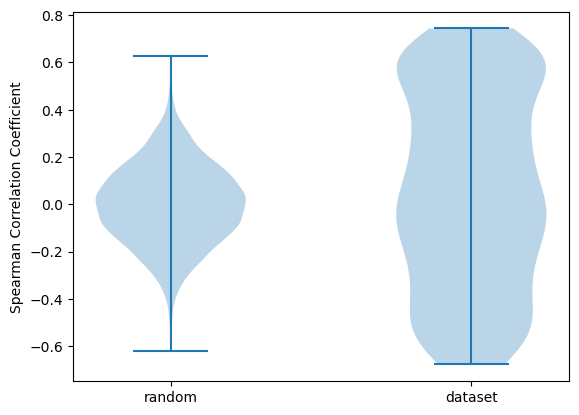

In [45]:
# Permutation test for Spearman correlation
# i.e. randomly permute depth label and compute Spearman correlation to get a null distribution
random_r = []
for j in range(50):
    for i in df.columns:
        random_depths = sample(list(metadata.depth_cm.astype(int)), len(metadata.depth_cm))
        random_r.append(stats.spearmanr(random_depths, df[i], alternative = 'two-sided').correlation)

# Plot null distribution next to actual dataset distribution of Spearman correlation coefficients
plt.violinplot([random_r, depth_r])
plt.xticks([1,2],['random', 'dataset'])
plt.ylabel('Spearman Correlation Coefficient')
plt.show()

In [46]:
# Print statistics related to null distribution
from scipy.stats import normaltest, norm
mu = np.mean(random_r)
sigma = np.std(random_r)
print(normaltest(random_r))
print("mean = " + str(mu))
print("std = " + str(sigma))

NormaltestResult(statistic=np.float64(20.79826604399459), pvalue=np.float64(3.0458878742346584e-05))
mean = -0.0004883020358155895
std = 0.17074600438591883


In [47]:
# Compute probability of actual dataset r values using the random null distribution
z_scores = []
p_vals = []
for i in depth_r:
    z = (i - mu)/sigma
    z_scores.append(z)
    p = norm.sf(abs(z))*2
    p_vals.append(p)

In [48]:
kruskal_res['spearman_p'] = p_vals
kruskal_res['spearman_pval_corr'] = fdrcorrection(p_vals, alpha=0.05)[1]

In [49]:
print('Number of modules significantly different by season: ' + str(np.sum(kruskal_res['season_pval_corr'] < 0.05)))
print('Number of modules significantly different by depth: ' + str(np.sum(kruskal_res['depth_pval_corr'] < 0.05)))
print('Number of modules significantly correlated by depth: ' + str(np.sum(kruskal_res['spearman_pval_corr'] < 0.05)))

Number of modules significantly different by season: 0
Number of modules significantly different by depth: 178
Number of modules significantly correlated by depth: 204


In [50]:
kruskal_res.to_csv('output/kegg_modules_stats.csv')

In [57]:
# Filter to show significantly correlated modules only and sort by R value
kruskal_res[kruskal_res.spearman_pval_corr<0.01].sort_values('spearman_r', ascending=False).head(50)

,season_pval,depth_pval,spearman_r,spearman_p,season_pval_corr,depth_pval_corr,spearman_pval_corr
"M00909UDP-GlcNAc biosynthesis, prokaryotes, Fru-6P => UDP-GlcNAc",0.950891,0.000062,0.743404,0.000013,0.997816,0.006561,0.001629
"M00096C5 isoprenoid biosynthesis, non-mevalonate pathway",0.556564,0.000140,0.694280,0.000047,0.997816,0.006561,0.001629
"M00554UDP-Gal biosynthesis, Gal => UDP-Gal",0.855729,0.000252,0.687730,0.000056,0.997816,0.006561,0.001629
"M00115NAD biosynthesis, aspartate => quinolinate => NAD",0.916797,0.000271,0.684455,0.000060,0.997816,0.006561,0.001629
"M00976C19-Steroid hormone biosynthesis, pregnenolone => testosterone => dihydrotestosterone",0.798345,0.000263,0.684455,0.000060,0.997816,0.006561,0.001629
"M00977C19-Steroid hormone biosynthesis (androgen backdoor pathway), pregnenolone => androsterone => dihydrotestosterone",0.798345,0.000263,0.684455,0.000060,0.997816,0.006561,0.001629
"M00914Coenzyme A biosynthesis, archaea, 2-oxoisovalerate => 4-phosphopantoate => CoA",0.906076,0.000320,0.677906,0.000071,0.997816,0.006561,0.001629
"M00896Thiamine biosynthesis, archaea, AIR (+ NAD+) => TMP/TPP",0.760167,0.000320,0.677906,0.000071,0.997816,0.006561,0.001629
"M00007Pentose phosphate pathway, non-oxidative phase, fructose 6P => ribose 5P",0.923811,0.000292,0.677906,0.000071,0.997816,0.006561,0.001629
"M00527Lysine biosynthesis, DAP aminotransferase pathway, aspartate => lysine",0.707789,0.000301,0.674631,0.000077,0.997816,0.006561,0.001629


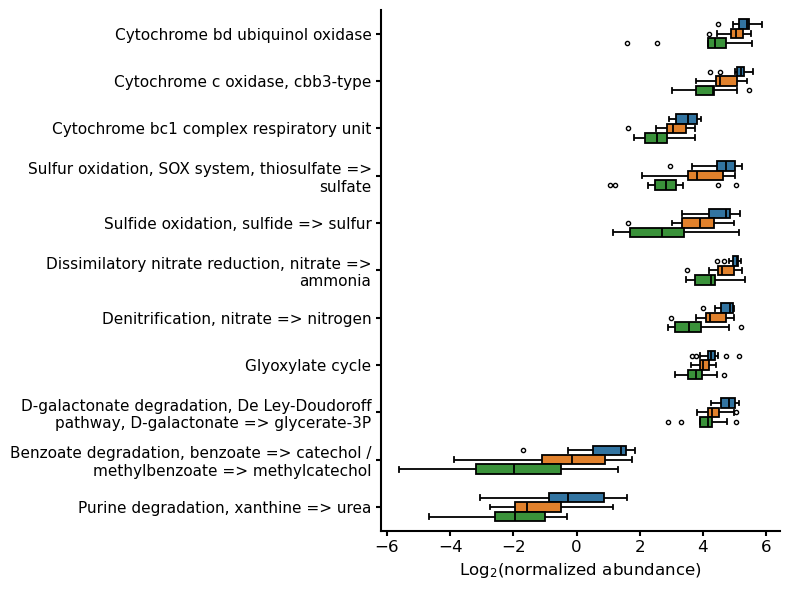

In [52]:
# Plot select modules abundant towards surface
fig, ax = plt.subplots(1,1,figsize=(8,6))
plot_modules = ['M00153Cytochrome bd ubiquinol oxidase',
        'M00156Cytochrome c oxidase, cbb3-type',
        'M00151Cytochrome bc1 complex respiratory unit',
        'M00595Sulfur oxidation, SOX system, thiosulfate => sulfate',
        'M00985Sulfide oxidation, sulfide => sulfur',
        'M00530Dissimilatory nitrate reduction, nitrate => ammonia',
        'M00529Denitrification, nitrate => nitrogen',
        'M00012Glyoxylate cycle',
        'M00552D-galactonate degradation, De Ley-Doudoroff pathway, D-galactonate => glycerate-3P',
        'M00551Benzoate degradation, benzoate => catechol / methylbenzoate => methylcatechol',
        'M00546Purine degradation, xanthine => urea']
sns.boxplot(data=df.melt(id_vars=['month', 'depth'], value_vars=plot_modules),
            y='variable', x='value', hue='depth', hue_order=['Top','Mid','Btm'],
            dodge=True, width=.6, fliersize=3, linewidth=1.3, linecolor='black',ax=ax)
sns.despine()
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.tick_params(width=1.5)

labels = ['\n'.join(wrap(x, 50)) for x in  plot_modules]
plt.yticks(np.arange(0,len(plot_modules)), [i[6:] for i in labels], fontsize=11, rotation=0)

plt.xticks(fontsize=12)
plt.xlabel('Log$_2$(normalized abundance)', size=12)
plt.ylabel('')
#plt.xlim([-7, 5])
ax.get_legend().remove()
plt.tight_layout()
plt.savefig('figures/top_modules.png', dpi=450)
plt.show()

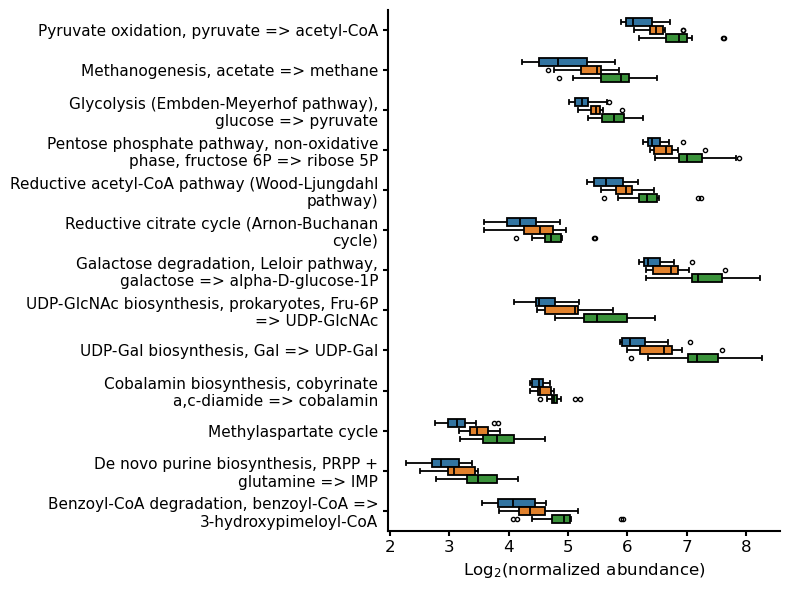

In [61]:
# Plot select modules abundant towards bottom
fig, ax = plt.subplots(1,1,figsize=(8,6))
plot_modules = ['M00307Pyruvate oxidation, pyruvate => acetyl-CoA',
                'M00357Methanogenesis, acetate => methane',
               'M00001Glycolysis (Embden-Meyerhof pathway), glucose => pyruvate',
               'M00007Pentose phosphate pathway, non-oxidative phase, fructose 6P => ribose 5P',
                'M00377Reductive acetyl-CoA pathway (Wood-Ljungdahl pathway)',
                'M00173Reductive citrate cycle (Arnon-Buchanan cycle)',
                'M00632Galactose degradation, Leloir pathway, galactose => alpha-D-glucose-1P',
               'M00909UDP-GlcNAc biosynthesis, prokaryotes, Fru-6P => UDP-GlcNAc',
               'M00554UDP-Gal biosynthesis, Gal => UDP-Gal',
               'M00122Cobalamin biosynthesis, cobyrinate a,c-diamide => cobalamin',
                'M00740Methylaspartate cycle',
               'M00048De novo purine biosynthesis, PRPP + glutamine => IMP',
               'M00541Benzoyl-CoA degradation, benzoyl-CoA => 3-hydroxypimeloyl-CoA']
sns.boxplot(df.melt(id_vars=['month', 'depth'], value_vars=plot_modules),
            y='variable', x='value', hue='depth', hue_order=['Top','Mid','Btm'],
            dodge=True, width=.6, fliersize=3, linewidth=1.3, linecolor='black',ax=ax)
sns.despine()
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.tick_params(width=1.5)

labels = ['\n'.join(wrap(x, 50)) for x in  plot_modules]
plt.yticks(np.arange(0,len(plot_modules)), [i[6:] for i in labels], fontsize=11, rotation=0)

plt.xticks(fontsize=12)
plt.xlabel('Log$_2$(normalized abundance)', size=12)
plt.ylabel('')
ax.get_legend().remove()
plt.tight_layout()
plt.savefig('figures/btm_modules.png', dpi=450)
plt.show()

In [ ]:
def get_paths(source, name="", target = None):
    '''Returns path in nested json of the target value/KO gene
    code modified from Stack Exchange: 
    https://stackoverflow.com/questions/73168515/find-nested-json-path-with-key-using-python'''
    if isinstance(source, dict):
        for source_key, source_value in source.items():
            source_name = source['name']
            tmp_name = f"{name}|{source_name}" if name else source_name
            if source_value[:6] == target:
                yield tmp_name
            else:
                yield from get_paths(source_value, tmp_name, target)
    elif isinstance(source, (list, tuple, set, frozenset)):
        for value in source:
            yield from get_paths(value, name, target)

In [ ]:
#Import json with KEGG KO to BRITE associations
brite_file = 'data/BRITE_json_ko00001.json'
with open(brite_file, "r") as f:
    data = json.loads(f.read())

In [ ]:
#Process significantly different genes for top versus bottom depths
marker_genes_1 = sig_genes[(sig_genes.spearman_pval_corr<0.01)&(sig_genes.spearman_r<0.)]
brites_1 = []
for i in marker_genes_1.index:
    for j in get_paths(data, target=str(i[0][3:])):
        brites_1.append(j.split('|')) 
df1 = pd.DataFrame(brites_1)
df1['depth'] = np.repeat('top', len(df1.index))

#Genes more abundant at bottom depth
marker_genes_2 = sig_genes[(sig_genes.spearman_pval_corr<0.01)&(sig_genes.spearman_r>0.)]
brites_2 = []
for i in marker_genes_2.index:
    for j in get_paths(data, target=str(i[0][3:])):
        brites_2.append(j.split('|')) 
df2 = pd.DataFrame(brites_2)
df2['depth'] = np.repeat('btm', len(df2.index))

combined = pd.concat([df1, df2])
combined['ko'] = 'KO:'+combined[4].str.split(expand=True)[0]
combined

In [ ]:
carb_genes = sig_genes.loc[combined[(combined[2]=='09101 Carbohydrate metabolism')&(combined.depth=='top')]['ko'].drop_duplicates()]

genes = list(carb_genes[carb_genes.spearman_r < 0.].sort_values('spearman_p').head(10).index)
df = plot_df.melt(id_vars=[('month',''), ('depth', '')], value_vars=genes)
df.rename({('month',''):'month', ('depth',''):'depth'}, axis=1, inplace=True) 

fig, ax = plt.subplots(1,1, figsize=(6, 5))
g = sns.boxplot(data=df, y='Function ID', x='value', hue='depth', dodge=True, width=.6, fliersize=3, linewidth=1.3, hue_order=['Top','Mid','Btm'])
sns.despine()
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.tick_params(width=1.5)

labels = ['\n'.join(wrap(x[1].split('[')[0], 40)) for x in  genes]
plt.yticks(np.arange(0,10), labels, fontsize=11, rotation=0)

plt.xticks(fontsize=12)
plt.xlabel('Log$_2$(normalized abundance)', size=12)
plt.ylabel('')
#plt.xlim([-11,8])
#ax.legend(handles = ax.get_legend_handles_labels()[0], title='Sample Depth', labels=['Top (0-20cm)', 'Middle (20-40cm)', 'Bottom (40-60cm)'],
#          fontsize=12, title_fontsize=12, edgecolor='black', bbox_to_anchor=(1.,1.))
ax.get_legend().remove()

plt.tight_layout()
plt.savefig('figures/carbohydrate_kos_depth_top10.png', dpi=450)
plt.show()

In [ ]:
carb_genes = sig_genes.loc[combined[(combined[2]=='09101 Carbohydrate metabolism')&(combined.depth=='btm')]['ko'].drop_duplicates()]

genes = list(carb_genes[carb_genes.spearman_r > 0.].sort_values('spearman_p').head(10).index)
df = plot_df.melt(id_vars=[('month',''), ('depth', '')], value_vars=genes)
df.rename({('month',''):'month', ('depth',''):'depth'}, axis=1, inplace=True) 

fig, ax = plt.subplots(1,1, figsize=(6, 5))
g = sns.boxplot(data=df, y='Function ID', x='value', hue='depth', dodge=True, width=.6, fliersize=3, linewidth=1.3, hue_order=['Top','Mid','Btm'])
sns.despine()
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.tick_params(width=1.5)

labels = ['\n'.join(wrap(x[1].split('[')[0], 40)) for x in  genes]
plt.yticks(np.arange(0,10), labels, fontsize=11, rotation=0)

plt.xticks(fontsize=12)
plt.xlabel('Log$_2$(normalized abundance)', size=12)
plt.ylabel('')
#plt.xlim([-11,8])

ax.legend(handles = ax.get_legend_handles_labels()[0], title='Sample Depth', labels=['Top (0-20cm)', 'Middle (20-40cm)', 'Bottom (40-60cm)'],
          fontsize=12, title_fontsize=12, edgecolor='black', bbox_to_anchor=(1.,1.05))
ax.get_legend().remove()

plt.tight_layout()
plt.savefig('figures/carbohydrate_kos_depth_btm10.png', dpi=450)
plt.show()

In [ ]:
carb_genes = sig_genes.loc[combined[(combined[2]=='09102 Energy metabolism')&(combined.depth=='top')]['ko'].drop_duplicates()]

genes = list(carb_genes[carb_genes.spearman_r < 0.].sort_values('spearman_p').head(10).index)
df = plot_df.melt(id_vars=[('month',''), ('depth', '')], value_vars=genes)
df.rename({('month',''):'month', ('depth',''):'depth'}, axis=1, inplace=True) 

fig, ax = plt.subplots(1,1, figsize=(6, 5))
g = sns.boxplot(data=df, y='Function ID', x='value', hue='depth', dodge=True, width=.6, fliersize=3, linewidth=1.3, hue_order=['Top','Mid','Btm'])
sns.despine()
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.tick_params(width=1.5)

labels = ['\n'.join(wrap(x[1].split('[')[0], 40)) for x in  genes]
plt.yticks(np.arange(0,10), labels, fontsize=11, rotation=0)

plt.xticks(fontsize=12)
plt.xlabel('Log$_2$(normalized abundance)', size=11.5)
plt.ylabel('')
#plt.xlim([-8,5])

ax.legend(handles = ax.get_legend_handles_labels()[0], title='Sample Depth', labels=['Top (0-20cm)', 'Middle (20-40cm)', 'Bottom (40-60cm)'],
          fontsize=12, title_fontsize=12, edgecolor='black', bbox_to_anchor=(1.,1.))
ax.get_legend().remove()

plt.tight_layout()
plt.savefig('figures/energy_metabolism_kos_top10.png', dpi=450)
plt.show()

In [ ]:
carb_genes = sig_genes.loc[combined[(combined[2]=='09102 Energy metabolism')&(combined.depth=='btm')]['ko'].drop_duplicates()]

genes = list(carb_genes[carb_genes.spearman_r > 0.].sort_values('spearman_p').head(10).index)
df = plot_df.melt(id_vars=[('month',''), ('depth', '')], value_vars=genes)
df.rename({('month',''):'month', ('depth',''):'depth'}, axis=1, inplace=True) 

fig, ax = plt.subplots(1,1, figsize=(6, 5))
g = sns.boxplot(data=df, y='Function ID', x='value', hue='depth', dodge=True, width=.6, fliersize=3, linewidth=1.3, hue_order=['Top','Mid','Btm'])
sns.despine()
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.tick_params(width=1.5)

labels = ['\n'.join(wrap(x[1].split('[')[0], 40)) for x in  genes]
plt.yticks(np.arange(0,10), labels, fontsize=11, rotation=0)

plt.xticks(fontsize=12)
plt.xlabel('Log$_2$(normalized abundance)', size=12)
plt.ylabel('')
#plt.xlim([-8,5])

ax.legend(handles = ax.get_legend_handles_labels()[0], title='Sample Depth', labels=['Top (0-20cm)', 'Middle (20-40cm)', 'Bottom (40-60cm)'],
          fontsize=12, title_fontsize=12, edgecolor='black', bbox_to_anchor=(1.,1.))
ax.get_legend().remove()

plt.tight_layout()
plt.savefig('figures/energy_metabolism_kos_btm10.png', dpi=450)
plt.show()

In [ ]:
combined.to_csv('output/kegg_categories_of_genes.csv')

In [ ]:
# Plot marker gene count per each KEGG metabolism category
fig, ax = plt.subplots(1, 2, figsize=(10,4))
cats = np.sort(list(set(combined[(combined[1]=='09100 Metabolism')][2])))
labels = [i[6:] for i in cats]
for i,k in enumerate(['top','btm']):
    tmp = combined[(combined[1]=='09100 Metabolism')&(combined.depth==k)][2].value_counts()
    vals = [tmp[j] if j in tmp.index else 0. for j in cats]
    sns.barplot(y=labels, x=vals, ax=ax[i], palette='tab20b', edgecolor='black')
    ax[i].set_title('Depth '+k)
    ax[i].set_ylabel('')
    #ax[i].set_xlim([0,160])
    print(vals)
    if i != 0:
        ax[i].set_yticks([]) 
plt.tight_layout()
plt.savefig('figures/09100_Metabolism_bar.png', dpi=300, facecolor='white')

In [ ]:
# Plot number of marker genes in the various subcategories of KEGG Metabolism
for j in set(combined[(combined[1]=='09100 Metabolism')][2]):
    fig, ax = plt.subplots(1, 2, figsize=(10,4))
    cats = np.sort(list(set(combined[(combined[2]==j)][3])))
    labels = [i.split('[')[0][6:] for i in cats]
    max_value = max(combined[combined[2]==j][3].value_counts())
    for i,k in enumerate(['top','btm']):
        tmp = combined[(combined[2]==j)&(combined.depth==k)][3].value_counts()
        vals = [tmp[j] if j in tmp.index else 0. for j in cats]
        print(labels)
        print(vals)
        sns.barplot(y=labels, x=vals, ax=ax[i], palette='tab20b', edgecolor='black')
        ax[i].set_title('Depth '+k)
        ax[i].set_ylabel('')
        ax[i].set_xlim([0,max_value+2])
        if i != 0:
            ax[i].set_yticks([])  
    plt.tight_layout()
    plt.savefig('figures/'+j+'_bar.png', dpi=300, facecolor='white')
    plt.show()

In [ ]:
#Plot number of marker genes in KEGG Brite Hierarchy categories
fig, ax = plt.subplots(1, 2, figsize=(10,10))
cats = np.sort(list(set(combined[(combined[1]=='09180 Brite Hierarchies')][3])))
labels = [i.split('[')[0][6:] for i in cats]

for i, k in enumerate(['top','btm']):
    tmp = combined[(combined[1]=='09180 Brite Hierarchies')&(combined.depth==k)][3].value_counts()
    vals = [tmp[j] if j in tmp.index else 0. for j in cats]
    print(vals)
    sns.barplot(y=labels, x=vals, ax=ax[i], palette='tab20b', edgecolor='black')
    ax[i].set_title('Depth '+k)
    ax[i].set_ylabel('')
    #ax[i].set_xlim([0,200])
    if i != 0:
        ax[i].set_yticks([])  
plt.tight_layout()
plt.savefig('figures/09180_Brite_Hierarchies_bar.png', dpi=300, facecolor='white')

In [ ]:
# Export just info about transporter kos
combined[combined[3]=='02000 Transporters [BR:ko02000]'].to_csv('output/transporters.csv')